<a href="https://colab.research.google.com/github/changsin/TDD/blob/main/tdd_python/notebooks/SOLID_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import matplotlib.pyplot as plt

In [45]:
import glob
import os

def glob_files(folder, file_type='*'):
    search_string = os.path.join(folder, file_type)
    files = glob.glob(search_string)

    print('Searching ', search_string)
    paths = []
    for f in files:
      if os.path.isdir(f):
        sub_paths = glob_files(f + '/')
        paths += sub_paths
      else:
        paths.append(f)

    # We sort the images in alphabetical order to match them
    #  to the annotation files
    paths.sort()

    return paths

def glob_folders(folder, file_type='*'):
    search_string = os.path.join(folder, file_type)
    files = glob.glob(search_string)

    print('Searching ', search_string)
    paths = []
    for f in files:
      if os.path.isdir(f):
        paths.append(f)

    # We sort the images in alphabetical order to match them
    #  to the annotation files
    paths.sort()

    return paths

In [23]:
DATA_ROOT = 'C:\\Users\\ChangsinLee\\SkNetworks_CarDashboard_21036\\01.rawData\\2차\\BMW\\'

In [422]:
from lxml import etree

def parse_xml(filename):
    image_labels = []

    tree = etree.parse(filename)
    for image in tree.xpath('image'):
        # print(image.attrib['name'])
        name = image.attrib['name']
        width = int(image.attrib['width'])
        height = int(image.attrib['height'])

        boxes = []

        for box in image.xpath('box'):
            xtl = float(box.attrib['xtl'])
            ytl = float(box.attrib['ytl'])
            xbr = float(box.attrib['xbr'])
            ybr = float(box.attrib['ybr'])

            alertwarning = box.attrib['label']
            wtype = box.xpath('attribute[@name="name"]')[0].text
            daynight = box.xpath('attribute[@name="daynight"]')[0].text
            visibility = int(box.xpath('attribute[@name="visibility"]')[0].text)

            box = wtype, alertwarning, daynight, visibility, xtl, ytl, xbr, ybr

            boxes.append(box)

        image_labels.append([name, width, height, np.array(boxes)])

    return np.array(image_labels)


In [423]:
def load_labels(path, file_type='*'):
    files = glob_files(path, file_type=file_type)
    print(files)

    y = []
    dfy = []

    for file in files:
        labels = parse_xml(file)
        y.append([os.path.basename(file), labels])
        for label in labels:
            filename = label[0]
            width = label[1]
            height = label[2]
            boxes = label[3]
            for box in boxes:
                wtype = box[0]
                alertwarning = box[1]
                day = box[2]
                visibility = box[3]

                xtl = box[4]
                ytl = box[5]
                xbr = box[6]
                ybr = box[7]

            # print(label)
                dfy.append([os.path.basename(file), filename, width, height, wtype, alertwarning, day, visibility, xtl, ytl, xbr, ybr])
    
    return np.array(y), np.array(dfy)

y, dfyy = load_labels(DATA_ROOT, file_type='*.xml')
y.shape
# image_labels = parse_xml('C:\\Users\\ChangsinLee\\SkNetworks_CarDashboard_21036\\01.rawData\\2차\\BMW\\BMW_day_0_1.xml')
# image_labels

Searching  C:\Users\ChangsinLee\SkNetworks_CarDashboard_21036\01.rawData\2차\BMW\*.xml
['C:\\Users\\ChangsinLee\\SkNetworks_CarDashboard_21036\\01.rawData\\2차\\BMW\\BMW_day_0_1.xml', 'C:\\Users\\ChangsinLee\\SkNetworks_CarDashboard_21036\\01.rawData\\2차\\BMW\\BMW_day_0_2.xml', 'C:\\Users\\ChangsinLee\\SkNetworks_CarDashboard_21036\\01.rawData\\2차\\BMW\\BMW_day_0_3.xml', 'C:\\Users\\ChangsinLee\\SkNetworks_CarDashboard_21036\\01.rawData\\2차\\BMW\\BMW_day_0_4.xml', 'C:\\Users\\ChangsinLee\\SkNetworks_CarDashboard_21036\\01.rawData\\2차\\BMW\\BMW_day_1_1.xml', 'C:\\Users\\ChangsinLee\\SkNetworks_CarDashboard_21036\\01.rawData\\2차\\BMW\\BMW_day_1_2.xml', 'C:\\Users\\ChangsinLee\\SkNetworks_CarDashboard_21036\\01.rawData\\2차\\BMW\\BMW_day_1_3.xml', 'C:\\Users\\ChangsinLee\\SkNetworks_CarDashboard_21036\\01.rawData\\2차\\BMW\\BMW_day_2_1.xml', 'C:\\Users\\ChangsinLee\\SkNetworks_CarDashboard_21036\\01.rawData\\2차\\BMW\\BMW_day_2_2.xml', 'C:\\Users\\ChangsinLee\\SkNetworks_CarDashboard_21036\\01

C:\Users\CHANGS~1\AppData\Local\Temp/ipykernel_31752/1285046348.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(image_labels)
C:\Users\CHANGS~1\AppData\Local\Temp/ipykernel_31752/1952157694.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(y), np.array(dfy)


(20, 2)

In [359]:
'BMW_day_2_4.xml'[:-6][-1]

'2'

In [267]:
def extract_labels(y):
    labels = []
    for a in y:
        # print(a.shape)  [0][:, 4:7]
        for b in a[1][:, 3]:
            for c in b:
                labels.append(c)
    return np.array(labels)

labels = extract_labels(y)

In [453]:
dfy = pd.DataFrame.from_records(dfyy)
dfy.head()


dfy.columns = ['folder', 'filename', 'width', 'height', 'class', 'alertwarning', 'daynight', 'visibility', 'xtl', 'ytl', 'xbr', 'ybr']
dfy.head()

dfy.drop(['filename', 'width', 'height', 'xtl', 'ytl', 'xbr', 'ybr'], inplace=True, axis=1)
dfy.head()

,folder,class,alertwarning,daynight,visibility
0,BMW_day_0_1.xml,StabilityOff,warning,day,1
1,BMW_day_0_1.xml,StabilityOn,warning,day,1
2,BMW_day_0_1.xml,Tire,warning,day,0
3,BMW_day_0_1.xml,Brake,alert,day,0
4,BMW_day_0_1.xml,Brake,alert,day,0


In [455]:

for i in range(len(dfy)):
    # print(dfy.loc[i]['category'])
    dfy.loc[i]['folder'] = dfy.loc[i]['folder'][-7]
    dfy.loc[i]['class'] = dfy.loc[i]['alertwarning'] + '@' + dfy.loc[i]['class']

dfy.drop('alertwarning', inplace=True, axis=1)
dfy.head()
# dfy.loc[0]['category'][-7]



,folder,class,daynight,visibility
0,0,warning@StabilityOff,day,1
1,0,warning@StabilityOn,day,1
2,0,warning@Tire,day,0
3,0,alert@Brake,day,0
4,0,alert@Brake,day,0


In [446]:
dfy.head()

,category,class,alertwarning,daynight,visibility
0,0,StabilityOff,warning,day,1
1,0,StabilityOn,warning,day,1
2,0,Tire,warning,day,0
3,0,Brake,alert,day,0
4,0,Brake,alert,day,0


In [457]:
dfy['daynight'] = pd.Categorical(dfy['daynight']).codes

# dfy['alertwarning'] = pd.Categorical(dfy['alertwarning']).codes

# reorder the columns
dfy = dfy[['class', 'daynight', 'folder', 'visibility']]

dfy.tail()


,class,daynight,folder,visibility
6203,warning@Engine,1,2,2
6204,alert@Seatbelt,1,2,2
6205,warning@Engine,1,2,1
6206,alert@Brake,1,2,0
6207,alert@Seatbelt,1,2,0


In [459]:
names = pd.unique(dfy['class'])

# dfs = dfy[dfy['class'] == 'Engine']
# dfs[dfs['alertwarning'] == 1]

In [467]:
print("\tclass\tzero-object-ratio\t0-in-f0-ratio\tnon-f0-ratio")
for name in names:
    dfys = dfy[dfy['class'] == name]

    # dfyw = dfy[dfy['class'] == name]

    total = len(dfys)
    total_zeros = len(dfys[dfys['visibility'] == '0'])
    # total objects in zero folder - there could more 1 or 2 visibility objects too
    zero_f_total = len(dfys[dfys['folder'] == '0'])

    df_fzeros = dfys[dfys['folder'] == '0']
    # pure zero visibility objects in zero folder
    zeros_in_zero_f = len(df_fzeros[df_fzeros['visibility'] == '0'])
    print("{}\t{} ({}/{})\t{} ({}/{})\t{} ({}/{})".format(
        name, round(total_zeros/total, 2), total_zeros, total,
            round(zeros_in_zero_f/zero_f_total, 2) if zero_f_total != 0 else 0, zeros_in_zero_f, zero_f_total,
            round((total_zeros - zeros_in_zero_f)/total_zeros, 2), total_zeros - zeros_in_zero_f, total_zeros))


	class	zero-object-ratio	0-in-f0-ratio	non-f0-ratio
warning@StabilityOff	0.33 (207/622)	0.56 (132/234)	0.36 (75/207)
warning@StabilityOn	0.34 (205/607)	0.5 (117/233)	0.43 (88/205)
warning@Tire	0.39 (255/651)	0.59 (160/273)	0.37 (95/255)
alert@Brake	0.44 (291/657)	0.9 (124/138)	0.57 (167/291)
alert@Seatbelt	0.47 (432/914)	0.65 (134/206)	0.69 (298/432)
warning@Steering	0.52 (213/410)	0.92 (109/119)	0.49 (104/213)
warning@Brake	0.28 (120/427)	0.41 (80/193)	0.33 (40/120)
warning@Engine	0.45 (483/1079)	0.68 (225/333)	0.53 (258/483)
alert@Retaining	0.4 (94/233)	0.69 (11/16)	0.88 (83/94)
warning@ABS	0.45 (141/314)	0.39 (47/121)	0.67 (94/141)
warning@CentralMonitoring	0.53 (28/53)	1.0 (5/5)	0.82 (23/28)
alert@EngineOilTemp	0.62 (147/239)	0.82 (62/76)	0.58 (85/147)
warning@EPC	0.5 (1/2)	0 (0/0)	1.0 (1/1)


In [308]:
import pandas as pd

df = pd.DataFrame.from_records(labels)
df.head()

to_drop = [0, 1, 2, 3]
df.drop(to_drop, inplace=True, axis=1)
df.head()

,4,5,6
0,StabilityOff,day,1
1,StabilityOn,day,1
2,Tire,day,0
3,Brake,day,0
4,Brake,day,0


In [338]:
names = df[4].drop_duplicates().astype('string')
print(names.astype('string'))


names[0]

0            StabilityOff
1             StabilityOn
2                    Tire
3                   Brake
18               Seatbelt
70               Steering
75                 Engine
273             Retaining
387                   ABS
625     CentralMonitoring
626         EngineOilTemp
2005                  EPC
Name: 4, dtype: string


'StabilityOff'

In [348]:
for name in names:
    dfs = df[df[4] == name]
    total = len(dfs)
    zeros = len(dfs[dfs[6] == '0'])
    print("{}: {} ({}/{})".format(name, round(zeros/total, 2), zeros, total))

StabilityOff: 0.33 (207/622)
StabilityOn: 0.34 (205/607)
Tire: 0.39 (255/651)
Brake: 0.38 (411/1084)
Seatbelt: 0.47 (432/914)
Steering: 0.52 (213/410)
Engine: 0.45 (483/1079)
Retaining: 0.4 (94/233)
ABS: 0.45 (141/314)
CentralMonitoring: 0.53 (28/53)
EngineOilTemp: 0.62 (147/239)
EPC: 0.5 (1/2)


In [325]:
dfs1 = df[(df[4]=='StabilityOff')]
dfs1[dfs1[6] == '0'].count()

4    207
5    207
6    207
dtype: int64

In [ ]:
columns = np.unique(labels[:, 4])

def query_labels(labels, columns):
    results = {}
    for c in columns:
        idx = np.where(labels[:, 4] == c)

        visibilities = {}
        for i in idx:
            vis = labels[:, 6]

            uniques = np.unique(vis)

            # print(type(vis[0]))
            # print(uniques)

            # for v in range(len(uniques)):
            #     print(np.where(vis == v))
                # visibilities[v] = np.where(vis == v).sum()

            # print(np.bincount(visibility))

            # if visibility in visibilities:
            #     visibilities[visibility] += 1
            # else:
            #     visibilities[visibility] = 1

        results[c] = visibilities

    return results

c = query_labels(labels, columns)


In [272]:
np.where(labels[:, 4] == 'Tire')

(array([   2,    6,   74,   81,   84,   91,   97,  100,  107,  111,  116,
         120,  124,  137,  143,  149,  162,  170,  173,  180,  184,  189,
         190,  195,  199,  204,  209,  213,  217,  219,  222,  227,  232,
         233,  247,  252,  259,  261,  269,  276,  282,  287,  290,  295,
         298,  302,  303,  310,  315,  324,  326,  329,  333,  340,  342,
         348,  352,  353,  359,  366,  374,  380,  384,  389,  397,  398,
         399,  409,  410,  413,  418,  422,  425,  426,  434,  449,  453,
         461,  463,  466,  472,  474,  476,  486,  489,  492,  493,  495,
         500,  505,  509,  513,  516,  517,  522,  525,  531,  538,  542,
         544,  551,  555,  562,  566,  570,  574,  576,  582,  587,  589,
         592,  594,  595,  596,  597,  598,  599,  600,  601,  602,  605,
         606,  608,  614,  618,  621,  622,  623,  650,  659,  664,  672,
         673,  680,  692,  700,  702,  712,  715,  724,  728,  736,  743,
         744,  756,  762,  771,  774, 

In [260]:
y

array([['BMW_day_0_1.xml',
        array([['20210715_111300 16.jpg', 1920, 1080,
                array([['1025.76', '554.38', '1055.4', '598.18', 'StabilityOff', 'day',
                        '1'],
                       ['964.89', '564.9', '995.22', '599.01', 'StabilityOn', 'day', '1'],
                       ['1024.57', '609.51', '1059.28', '640.81', 'Tire', 'day', '0'],
                       ['962.6', '612.1', '1003.54', '641.5', 'Brake', 'day', '0']],
                      dtype='<U32')                                                       ],
               ['20210715_111300 17.jpg', 1920, 1080,
                array([['1002.95', '616.3', '1044.1', '648.0', 'Brake', 'day', '0'],
                       ['1004.76', '569.71', '1035.1', '602.93', 'StabilityOn', 'day',
                        '1'],
                       ['1064.2', '614.77', '1099.46', '646.5', 'Tire', 'day', '0'],
                       ['1065.25', '558.99', '1095.58', '602.2', 'StabilityOff', 'day',
                

In [164]:
import numpy as np

result1 = np.array([[0.813, 0.043, 0.677],
                    [0.722, 0.063, 0.333],
                    [0.672, 0.062, 1.233],
                    [0.771, 0.051, 0.765],
                    [0.881, 0.045, 0.462]])

result2 = np.array([[0.459, 0.051, 0.717],
                    [0.909, 0.049, 0.933],
                    [0.0  , 0.059, 0.833],
                    [0.889, 0.055, 0.882],
                    [0.769, 0.053, 0.692]])

result3 = np.array([[0.559, 0.041, 0.881],
                    [0.509, 0.099, 0.833],
                    [0.306, 0.079, 0.933],
                    [0.589, 0.085, 0.782],
                    [0.769, 0.083, 0.592]])

In [93]:
import matplotlib.pyplot as plt

def plot_stats(stats, types, titles):
  x_bar = np.arange(stats[0].shape[0])
  bar_width = .35

  fig = plt.figure(figsize=(20,40))

  for i, stat in zip(range(len(stats)), stats):
    ax = fig.add_subplot(10, 4, i+1)
    # plt.axis('off')

    for t in types:
      if "mAP" == t:
        rects1 = ax.bar(x_bar - bar_width/3, stat[:, 0], label="mAP")
      if "std" == t:
        rects2 = ax.bar(x_bar, stat[:, 1], label="std")
      if "accuracy" == t:
        rects3 = ax.bar(x_bar + bar_width/3, stat[:, 2], label="accuracy")

    ax.set_xticks(x_bar)
    ax.set_xticklabels(x_bar)
    ax.set_title(titles[i])

    ax.legend()

  fig.tight_layout()

# plot line graph for comparing different noise level results
def plot_stats_by_type(stats, metric_type, x_bins, axis=None):

  if axis is None:
    fig = plt.figure(figsize=(20,40))
    axis = fig.add_subplot(10, 4, 1)

  x_bins_len = len(x_bins)
  n_clusters = stats.shape[1]
  for cluster_id in range(n_clusters):
    if "mAP" == metric_type:
        p = axis.plot(x_bins, stats[:x_bins_len, :, 0][:, cluster_id], label=cluster_id)
    if "std" == metric_type:
        p = axis.plot(x_bins, stats[:x_bins_len, :, 1][:, cluster_id], label=cluster_id)
    if "accuracy" == metric_type:
        p = axis.plot(x_bins, stats[:x_bins_len, :, 2][:, cluster_id], label=cluster_id)

  axis.set_title(metric_type)
  axis.legend()
  return axis

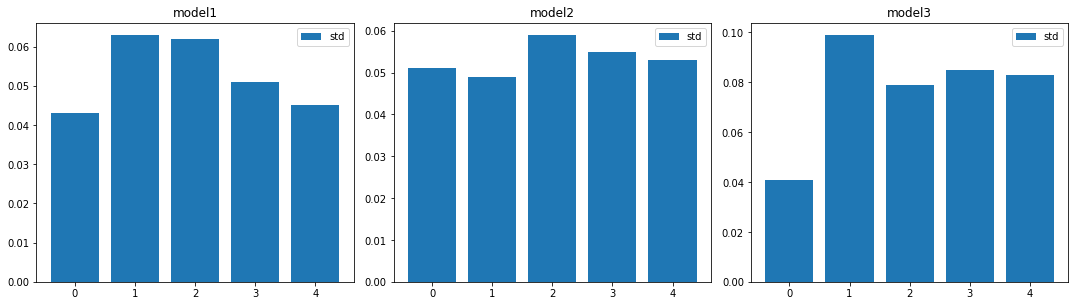

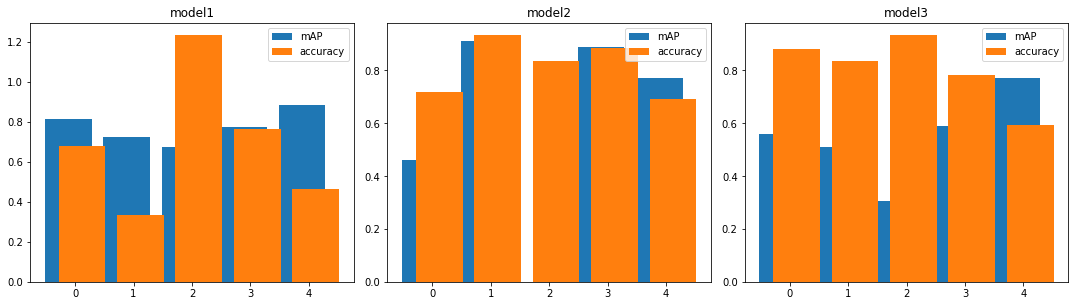

In [94]:
plot_stats([result1, result2, result3], ["std"], ["model1", "model2", "model3"] )
plot_stats([result1, result2, result3], ["mAP", "accuracy"], ["model1", "model2", "model3"] )

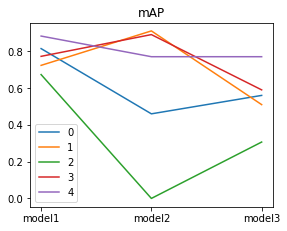

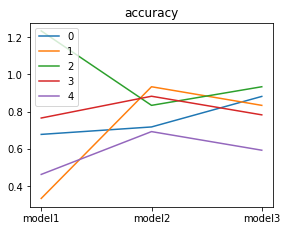

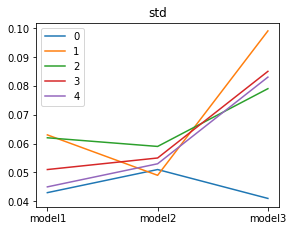

In [95]:
axis1 = plot_stats_by_type(np.array([result1, result2, result3]), 'mAP', ['model1', 'model2', 'model3'])
axis2 = plot_stats_by_type(np.array([result1, result2, result3]), 'accuracy', ['model1', 'model2', 'model3'])
axis3 = plot_stats_by_type(np.array([result1, result2, result3]), 'std', ['model1', 'model2', 'model3'])